In suitable units, the Schrodinger equation for a particle moving in a potential $V$ is
\begin{equation}
    \frac{d^2\psi}{dx^2} + (E - V (x)) \psi = 0
\end{equation}
where $\psi$ is the wavefunction and $E$ is the energy. We suppose that $V$ is periodic, in which case the Schrodinger equation may be considered to be a model for an electron in a crystal lattice. We seek solutions to the Schrodinger equation such that $\psi$ remains finite as $|x| \to \infty$, known as allowed solutions and then we will verify that the energy values $E$
for these solutions form a band structure.

If $V(x)$ is periodic with period $l$, then the allowed solutions can always be written as linear combinations of Bloch functions. These are functions such that
\begin{equation}
    \psi(x) = e^{ikx}v(x), \quad v(x + l) = v(x),
\end{equation}
where $k$ is a real number. We see that $v(x)$ is a periodic function with the same period as $V$, but $\psi(x)$ does not necessarily have this property.

Consider a specific choice for $V(x)$, which is an even function $V(x) = V(-x)$, formed from an infinite series of nearly parabolic sections, each of width $2a$. For positive $x$,
\begin{equation}
    V(x) = 1 − \cosh (x − (2r + 1)a),
\end{equation}
where $r = \lfloor x/2a \rfloor$.


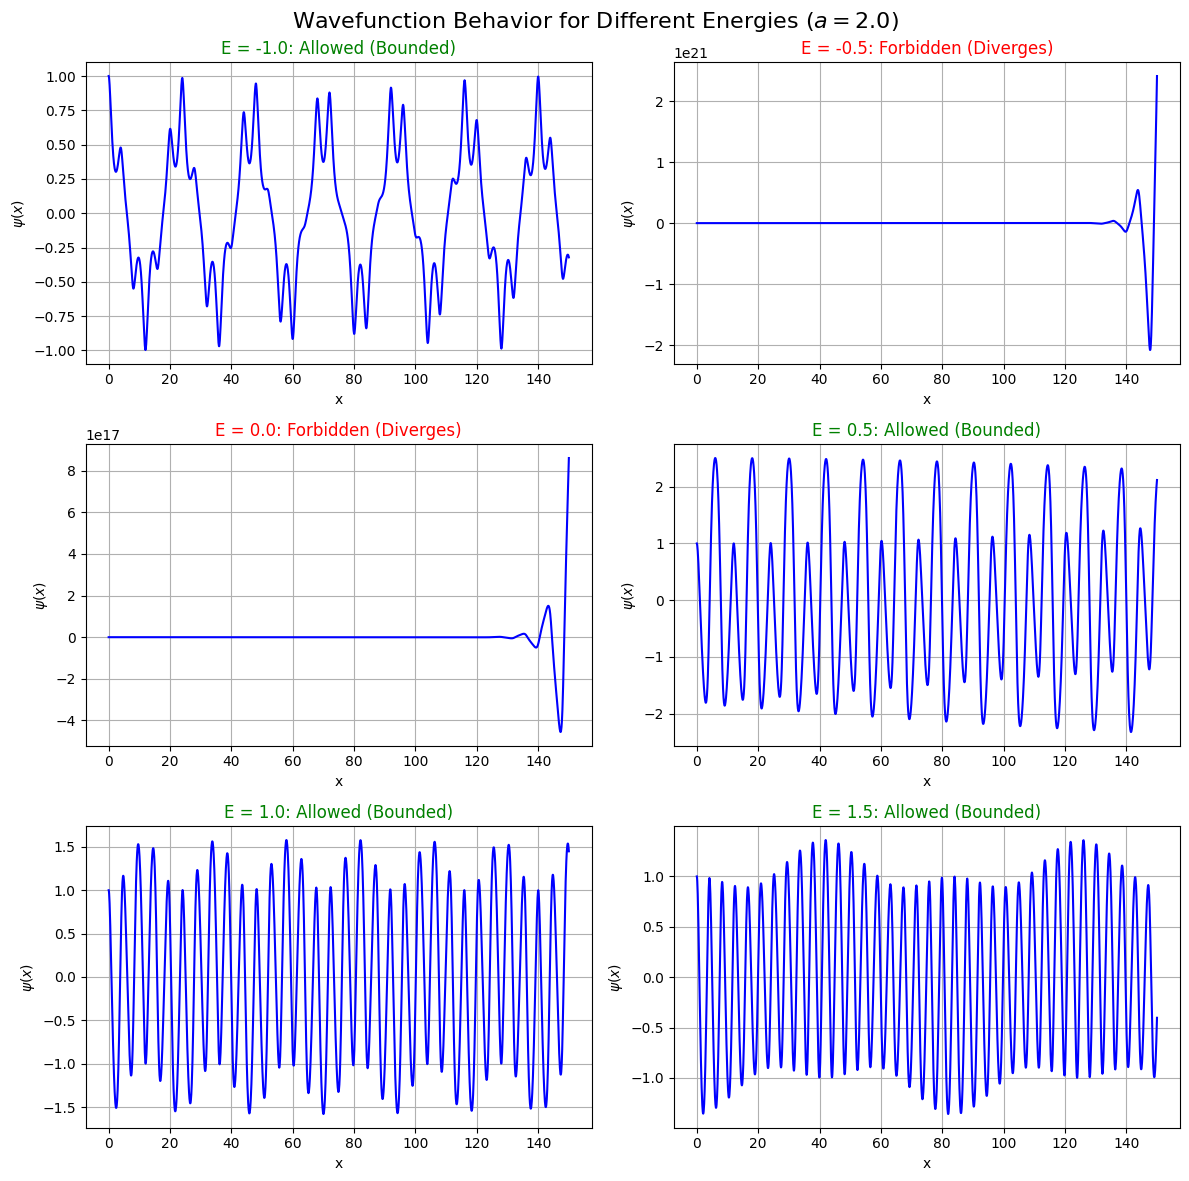

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def get_potential(x, a):
    '''
    Calculates the potential V(x) at a given point x
    '''
    x_abs = np.abs(x)
    r = np.floor(x_abs / (2 * a))
    term = x_abs - (2 * r + 1) * a
    V_x = 1 - np.cosh(term)
    return V_x

def schrodinger_system(x, y, E, a):
    '''
    Represents the system of first-order ODEs for the solver.
    '''
    psi = y[0]
    phi = y[1]

    dpsi_dx = phi
    dphi_dx = (get_potential(x, a) - E) * psi

    return [dpsi_dx, dphi_dx]

def run_simulation(E, a, x_max, boundary_conditions):
    '''
    Runs the numerical integrator for a single energy E.
    '''
    # Unpack boundary conditions [psi(0), psi'(0)]
    y0 = boundary_conditions

    # Define range and evaluation points
    x_span = (0, x_max)
    x_eval = np.linspace(0, x_max, 2000)

    solution = solve_ivp(
        fun=lambda x, y: schrodinger_system(x, y, E, a),
        t_span=x_span,
        y0=y0,
        t_eval=x_eval,
        method='RK45',
        rtol=1e-8,
        atol=1e-8
    )
    return solution.t, solution.y[0]

def plot_band_structure_search(energies, a, x_max, boundary_conditions):
    '''
    Runs the simulation for a list of energies and plots them in a grid.
    '''
    num_plots = len(energies)
    cols = 2
    rows = (num_plots + 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    fig.suptitle(f"Wavefunction Behavior for Different Energies ($a={a}$)", fontsize=16)
    axs = axs.flatten()

    for i, E in enumerate(energies):
        x, psi = run_simulation(E, a, x_max, boundary_conditions)

        # Determine if it looks bounded
        max_amp = np.max(np.abs(psi))
        is_divergent = max_amp > 20
        status = "Forbidden (Diverges)" if is_divergent else "Allowed (Bounded)"
        color = "red" if is_divergent else "green"

        axs[i].plot(x, psi, label=r'$\psi(x)$', color='blue')
        axs[i].set_title(f"E = {E}: {status}", color=color)
        axs[i].set_xlabel("x")
        axs[i].set_ylabel(r"$\psi(x)$")
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

# Parameters
param_a = 2.0
param_xmax = 150.0
boundaries = [1.0, 0.0]

test_energies = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
plot_band_structure_search(test_energies, param_a, param_xmax, boundaries)


*   Allowed solutions: The wavefunction $\psi(x)$ remains finite and oscillatory and is modulated by the periodicity of the potential. These energies correspond to the allowed energy bands of the crystal where electrons can propagate through the lattice. These are found close to $E = -1.5$ (valence-like bands trapped in the wells) or close to $E = 2.0$ (conduction-like bands above the potential maxima).

*   Forbidden solutions: The wavefunction diverges exponentially as $x$ increases. These energies lie in the band gaps. Physically, wavefunctions at these energies cannot exist (are evanescent) as extended states in the crystal.

In a forbidden gap, the mathematical solution is a combination of growing $e^{\kappa x}$ and decaying $e^{-\kappa x}$ exponentials. The numerical rounding errors are actually useful here as the instability makes forbidden energies easier to spot. For allowed energies, the solution is oscillatory. Over a long distance, small truncation errors can accumulate, leading to a phase shift but the amplitude still remains finite.


In [ ]:
def divergence_event(t, y):
    '''
    Returns 0 when psi hits the threshold, stopping the solver.
    '''
    threshold = 100.0  # If psi > 100, we consider it divergent
    return np.abs(y[0]) - threshold

divergence_event.terminal = True
divergence_event.direction = 0

def check_if_allowed(E, a, x_max, y0):
    '''
    Returns True if allowed (bounded), False if forbidden (diverges).
    '''
    sol = solve_ivp(
        fun=lambda x, y: schrodinger_system(x, y, E, a),
        t_span=(0, x_max),
        y0=y0,
        method='RK45',
        events=divergence_event,
        rtol=1e-6, atol=1e-6
    )

    if sol.status == 1:
        return False
    if np.max(np.abs(sol.y[0])) > 100:
        return False

    return True

def find_boundaries(start, end, a, x_max, y0):
    '''
    Scans quickly using a coarse step, then refines locally.
    '''
    boundaries = []

    # Coarse scan
    coarse_step = 0.1
    energies_coarse = np.arange(start, end + coarse_step, coarse_step)

    # Get initial status
    prev_status = check_if_allowed(energies_coarse[0], a, x_max, y0)

    for i in range(1, len(energies_coarse)):
        E_curr = energies_coarse[i]
        curr_status = check_if_allowed(E_curr, a, x_max, y0)

        # If status flipped, then the boundary is in the previous interval
        if curr_status != prev_status:
            # Fine scan
            E_low = energies_coarse[i-1]
            E_high = E_curr
            fine_step = 0.01
            energies_fine = np.arange(E_low, E_high + fine_step/2, fine_step)

            sub_prev_status = check_if_allowed(energies_fine[0], a, x_max, y0)

            for E_fine in energies_fine:
                sub_curr_status = check_if_allowed(E_fine, a, x_max, y0)
                if sub_curr_status != sub_prev_status:
                    boundary_val = round(E_fine - fine_step/2, 2)
                    boundaries.append(boundary_val)
                    # Avoid double counting
                    prev_status = curr_status
                    break
                sub_prev_status = sub_curr_status

        prev_status = curr_status

    return boundaries


def plot_solution(E, a, x_max, y0, ax):
    '''
    Plot a single solution on a given axis.
    '''
    sol = solve_ivp(
        fun=lambda x, y: schrodinger_system(x, y, E, a),
        t_span=(0, x_max),
        y0=y0,
        t_eval=np.linspace(0, x_max, 500),
        method='RK45'
    )
    ax.plot(sol.t, sol.y[0], label=f'E={E}')
    ax.set_title(f'Energy E = {E}')
    ax.set_xlabel('x')
    ax.grid(True)

Final Even Boundaries: [np.float64(-1.04), np.float64(-0.81), np.float64(0.3), np.float64(1.7), np.float64(1.78)]
Final Odd Boundaries: [np.float64(-1.04), np.float64(-0.81), np.float64(0.3), np.float64(1.7), np.float64(1.76)]


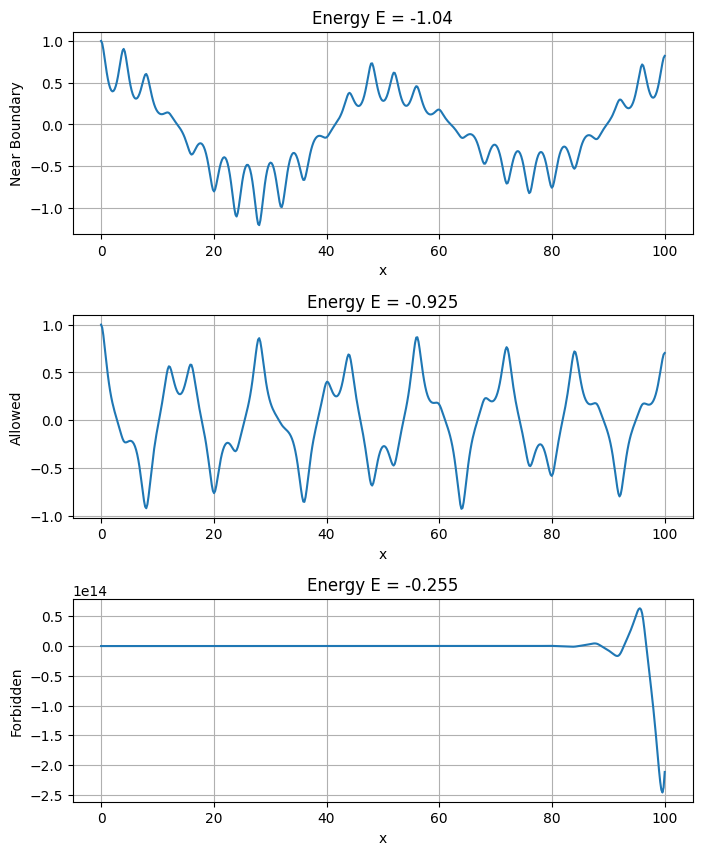

In [ ]:
# Parameters
a = 2.0
x_max = 300
y0_even = [1.0, 0.0]
y0_odd  = [0.0, 1.0]

bounds_even = find_boundaries(-1.5, 2.0, a, x_max, y0_even)
print(f"Final Even Boundaries: {bounds_even}")
bounds_odd = find_boundaries(-1.5, 2.0, a, x_max, y0_odd)
print(f"Final Odd Boundaries: {bounds_odd}")

fig, axs = plt.subplots(3, 1, figsize=(8, 10))
plt.subplots_adjust(hspace=0.4)

plot_solution(bounds_even[0], a, 100, y0_even, axs[0])
axs[0].set_ylabel("Near Boundary")

allowed_mid = (bounds_even[0] + bounds_even[1]) / 2
plot_solution(allowed_mid, a, 100, y0_even, axs[1])
axs[1].set_ylabel("Allowed")

forbidden_mid = (bounds_even[1] + bounds_even[2]) / 2
plot_solution(forbidden_mid, a, 100, y0_even, axs[2])
axs[2].set_ylabel("Forbidden")

plt.show()